# Install Dependencies

In [6]:
!python -m pip install beautifulsoup4 yfinance

# Import Dependencies

In [7]:
from bs4 import BeautifulSoup
import requests
import yfinance as yf
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import pandas as pd
from datetime import datetime
import json

AttributeError: module 'matplotlib._api' has no attribute 'caching_module_getattr'

# Config

In [ ]:
purchased_symbols = {
    'TSLA': ('Tesla Inc.', datetime(2022, 7, 28, 0, 0)),
    'AAPL': ('Apple Inc.', datetime(2022, 6, 28, 0, 0))
}

In [ ]:
with open('./../../data/easy_equities_us_stocks.json', 'r') as f:
    available_us_stock = json.load(f)

NameError: name 'json' is not defined

# Implementation

In [ ]:
def get_html_page(url: str) -> object:
    response: requests.Response = requests.get(url=url, headers={
        'User-Agent': 'PostmanRuntime/7.29.0'
    })
    response_text: str = response.text

    return BeautifulSoup(response_text, 'html.parser')

In [ ]:
class ValuationResult(object):
    def __init__(self,
                 symbol: str,
                 company_name: str,
                 current_price: float,
                 valuation_price: float,
                 annual_dividend_percentage: float,
                 purchased_price: float = None):
        self.symbol = symbol
        self.company_name = company_name
        self.current_price = current_price
        self.valuation_price = valuation_price
        self.absolute_current_v_valuation_delta = 1 - (min(valuation_price, current_price) / max(valuation_price, current_price))
        self.is_overvalued = valuation_price < current_price
        self.annual_dividend_percentage = annual_dividend_percentage
        self.purchased_price = purchased_price

In [ ]:
def determine_intrinsic_value_for_symbol(symbol: str, company_name: str) -> ValuationResult:
    symbol_summary_url = f'https://finviz.com/quote.ashx?t={symbol}'
    symbol_summary_html = get_html_page(url=symbol_summary_url)

    eps_ttm: float = float(symbol_summary_html.find(text='EPS (ttm)').find_next(class_='snapshot-td2').text)
    eps_five_years: float = float(symbol_summary_html.find(text='EPS next 5Y').find_next(class_='snapshot-td2').text.replace('%', '')) / 100
    
    pe_ratio: float = float(symbol_summary_html.find(text='P/E').find_next(class_='snapshot-td2').text)
    forward_pe_ratio: float = float(symbol_summary_html.find(text='Forward P/E').find_next(class_='snapshot-td2').text)
    avg_pe_ratio: float = (pe_ratio + forward_pe_ratio) / 2
    current_price: float = float(symbol_summary_html.find(text='Price').find_next(class_='snapshot-td2').text)
    
    annual_dividend_percentage: float = None
    annual_dividend_percentage_str = symbol_summary_html.find(text='Dividend %').find_next(class_='snapshot-td2').text.split('%')[0]
    
    if '-' not in annual_dividend_percentage_str:
        annual_dividend_percentage = float(annual_dividend_percentage_str)
    
    print(f'EPS: {eps_ttm}, EPS Next 5 Years: {eps_five_years}%, P/E Ratio: {avg_pe_ratio}, Current Price: $ {current_price}')
    
    intrinsic_value: float = determine_intrinsic_value(eps_ttm=eps_ttm,
                          growth_rate=eps_five_years,
                          pe_ratio=avg_pe_ratio,
                          margin_of_safety=0.3)

    print(f'Intrinsic Value: $ {intrinsic_value} vs. Current Price: $ {current_price}')

    return ValuationResult(
        symbol=symbol,
        company_name=company_name,
        current_price=current_price,
        valuation_price=intrinsic_value,
        annual_dividend_percentage=annual_dividend_percentage
    )

In [ ]:
def determine_intrinsic_value(eps_ttm: float, # Total trailing annual earnings per share.
                              growth_rate: float, # Projected 5 year EPS.
                              pe_ratio: float, # Price per earnings growth rate. 2x growth_rate if unsure.
                              min_rate_of_return: float = 0.15, # Rate of return we want to make.
                              margin_of_safety: float = 0.3 # Margin to padd our valuation with in order to mitigate risk. 20-50% usually.
                              ) -> float:
    assert eps_ttm > 1
    assert growth_rate > 0 and growth_rate < 1
    assert pe_ratio > 1
    assert min_rate_of_return > 0 and min_rate_of_return < 1
    assert margin_of_safety > 0 and margin_of_safety < 1
    
    target_ten_year_eps: float = eps_ttm

    for year in range(2, 11):
        target_ten_year_eps *= (1 + growth_rate)

    target_ten_year_share_price: float = target_ten_year_eps * pe_ratio
    target_share_price: float = target_ten_year_share_price

    for year in range(2, 11):
        target_share_price /= (1 + growth_rate)

    return target_share_price / (1 + margin_of_safety)

In [ ]:
def get_plot_for_symbol(symbol: str, 
                        days_to_visualize: int, 
                        symbol_data: pd.DataFrame,
                        valuation: ValuationResult,
                        purchase_date: datetime = None, 
                        fontsize: int = 7) -> object:
    if purchase_date is not None:
        days_to_visualize = (datetime.now() - purchase_date).days
        valuation.purchased_price = symbol_data[-days_to_visualize:].Close.values[0]
    
    with plt.rc_context({
            'lines.linewidth': 0.75,
            'figure.figsize': (6, 3)
        }):
        data_to_visualize = symbol_data[-days_to_visualize:].Close
        fig, ax = plt.subplots(dpi=600)
        plot = data_to_visualize.plot(ax=ax, color='r' if symbol_data.iloc[-days_to_visualize].Close > symbol_data.iloc[-1].Close else 'g', fontsize=fontsize)
        mid = (fig.subplotpars.right + fig.subplotpars.left)/2
        fig.suptitle(f'{symbol} ({days_to_visualize} Days)', fontsize=fontsize+2, x=mid)
        
        if valuation.annual_dividend_percentage is not None:
            ax.set_title(f'Annual Dividend Yield: {round(valuation.annual_dividend_percentage, 2)}%', fontdict={'fontsize': fontsize, 'fontweight': 'light'})
        
        plot.set_xlabel('')
        plot.set_ylabel('')
        
        tick = mtick.StrMethodFormatter('${x:,.0f}')
        valuation_delta: float = round(valuation.absolute_current_v_valuation_delta * 100, 2)
        
        plot.yaxis.set_major_formatter(tick) 
        plot.axhline(valuation.current_price, linestyle='--', label=f'Close (${round(valuation.current_price, 2)})')
        plot.axhline(valuation.valuation_price, color=('r' if valuation.is_overvalued else 'g'), linestyle='--', label=f'Valuation (${round(valuation.valuation_price, 2)} | Δ{valuation_delta}%)')
        
        plot.axvline(symbol_data.index.values[-(1+1)], linestyle='-.', color='y')

        if days_to_visualize > 7:
            plot.axvline(symbol_data.index.values[-(1+7)], linestyle='-.', color='y')
        
        if days_to_visualize > 30:
            plot.axvline(symbol_data.index.values[-(1+30)], linestyle='-.', color='y')
        
        if days_to_visualize > 30*6:
            plot.axvline(symbol_data.index.values[-(1+30*6)], linestyle='-.', color='y')
        
        if days_to_visualize > 365:
            plot.axvline(symbol_data.index.values[-(1+365)], linestyle='-.', color='y')

        if days_to_visualize > (365*5):
            plot.axvline(symbol_data.index.values[-(1+365*5)], linestyle='-.', color='y')

        if days_to_visualize > (365*10):
            plot.axvline(symbol_data.index.values[-(1+365*10)], linestyle='-.', color='y')
        
        handles, labels = plot.get_legend_handles_labels()
        plot.legend(handles=handles[1:], labels=labels[1:], fontsize=fontsize)

        return plot

# Usage

EPS: 8.33, EPS Next 5 Years: 0.5189%, P/E Ratio: 83.16499999999999, Current Price: $ 925.9
Intrinsic Value: $ 532.8957307692306 vs. Current Price: $ 925.9
EPS: 6.05, EPS Next 5 Years: 0.0983%, P/E Ratio: 26.525, Current Price: $ 165.81
Intrinsic Value: $ 123.44326923076925 vs. Current Price: $ 165.81


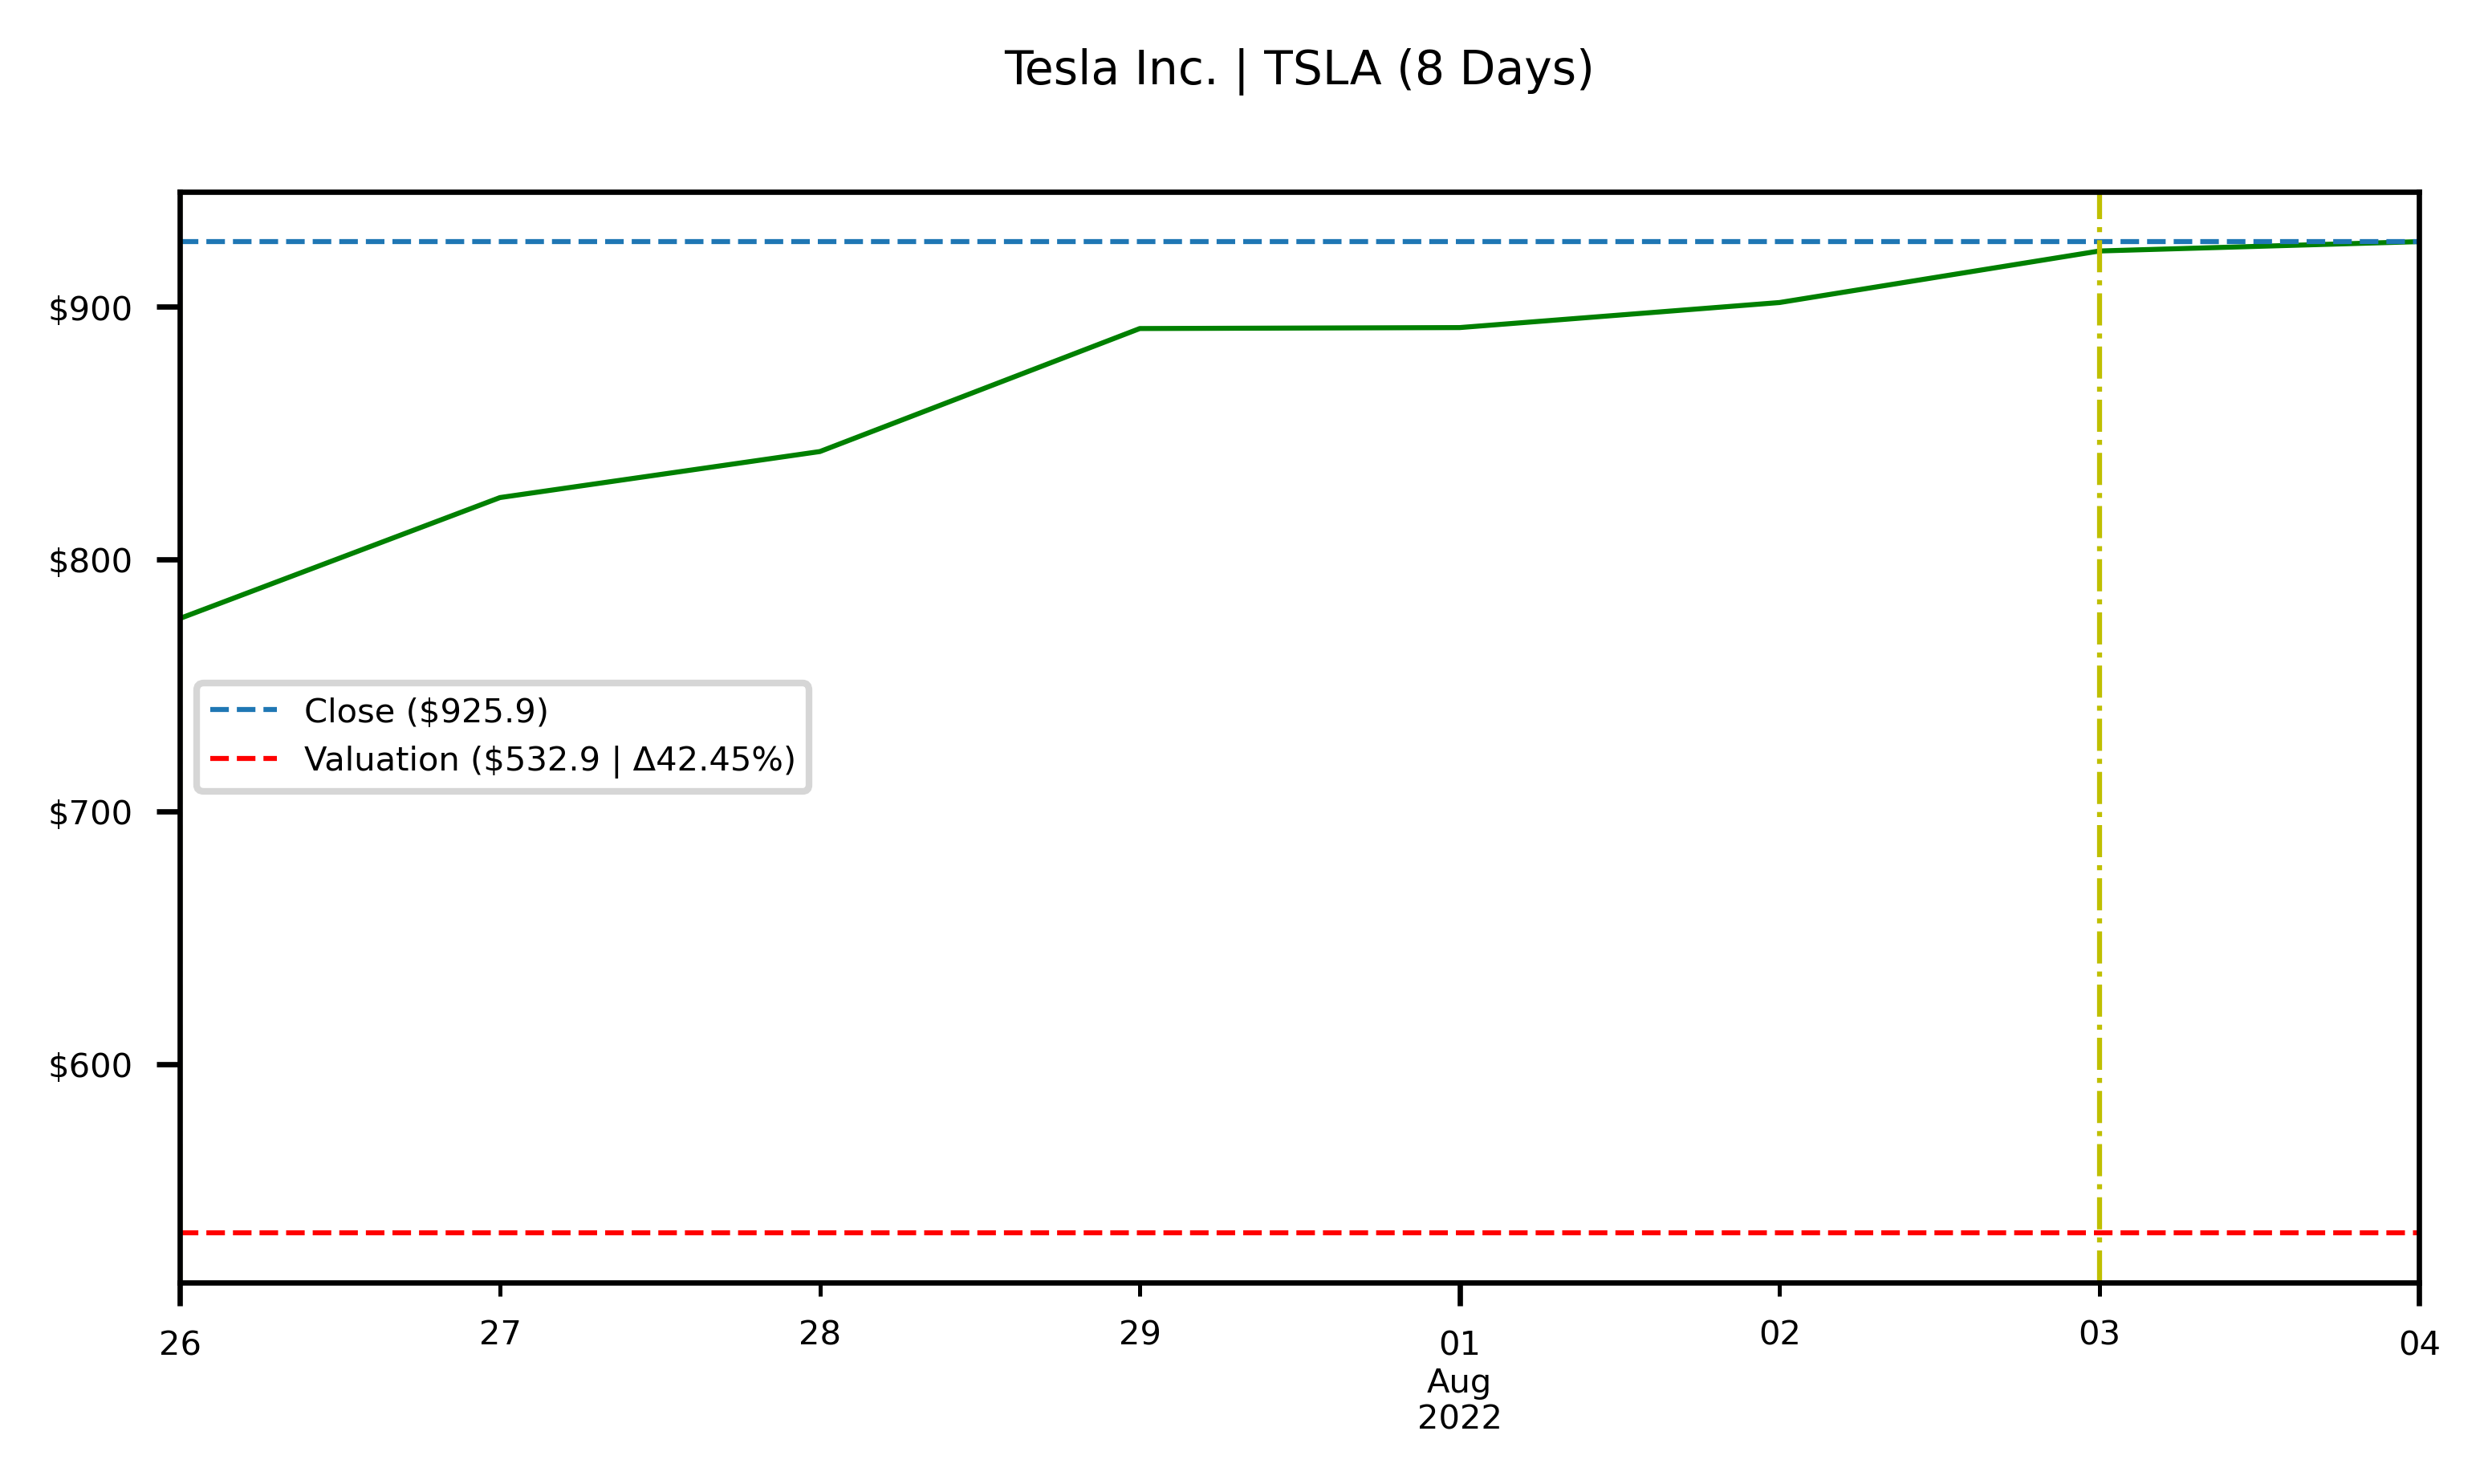

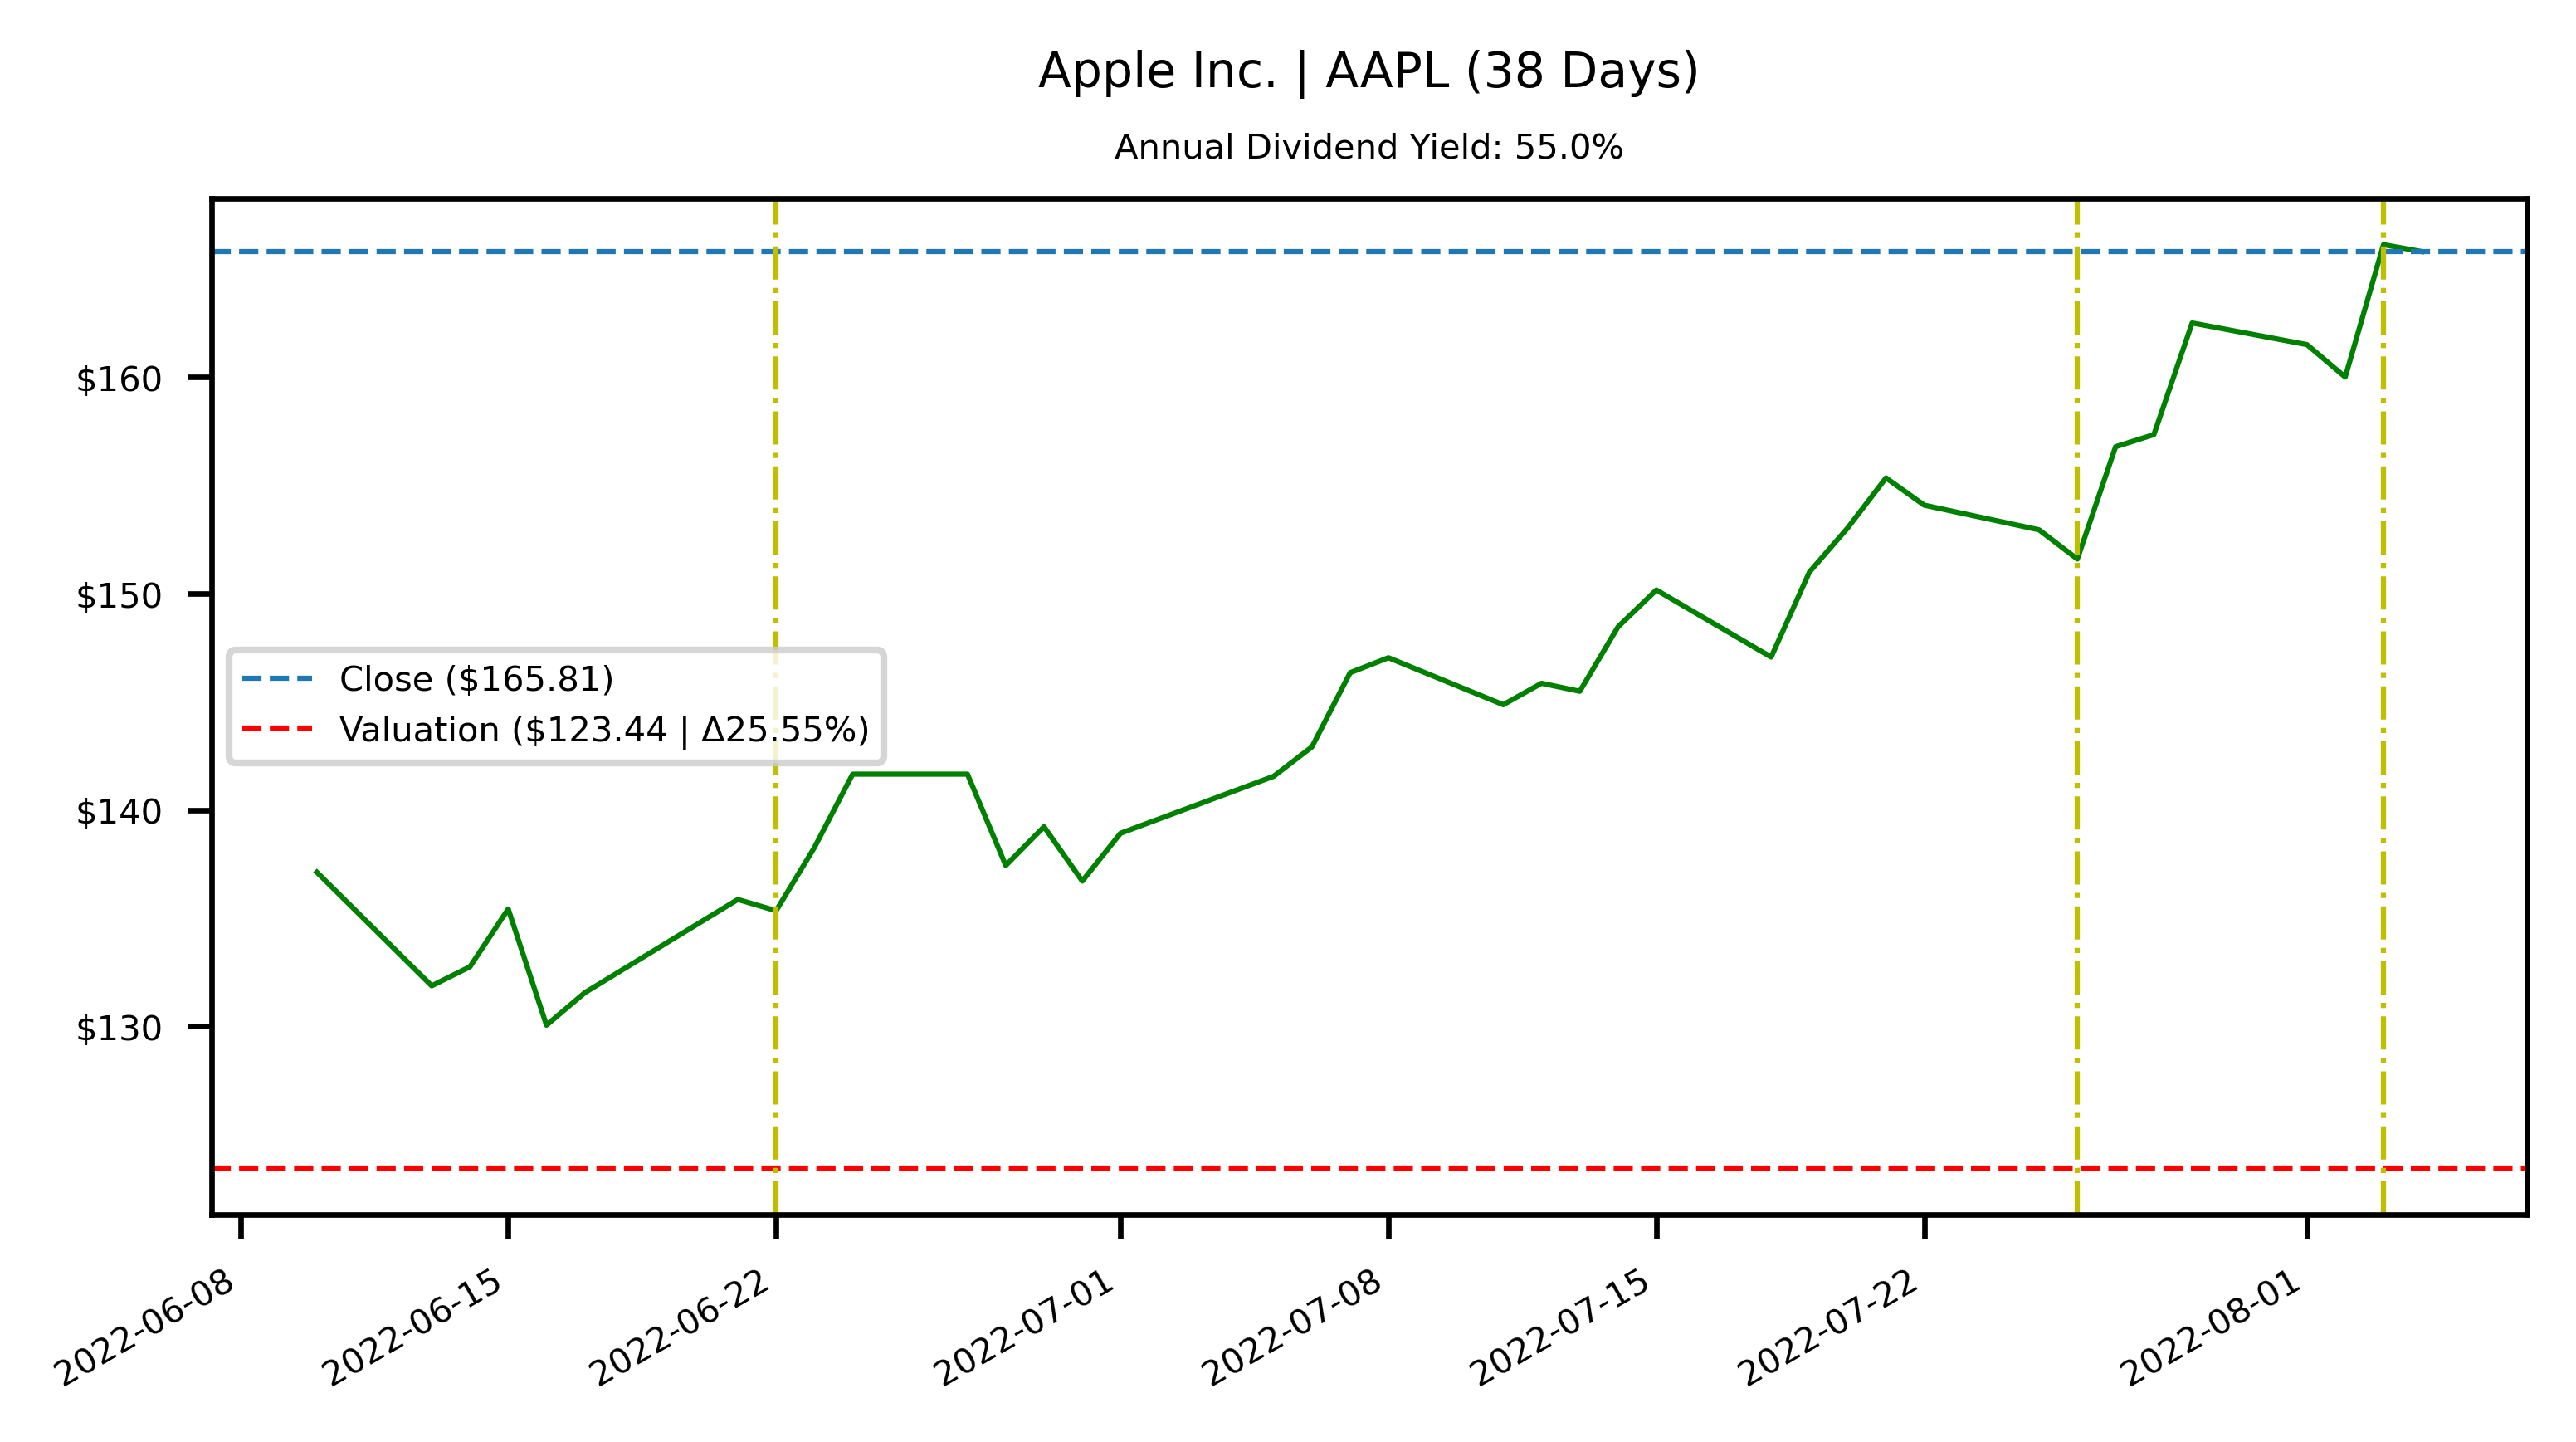

In [ ]:
owned_plots = list()
should_render_owned_stocks = True

if should_render_owned_stocks:
    for symbol in purchased_symbols:
        valuation = determine_intrinsic_value_for_symbol(symbol=symbol, company_name=purchased_symbols[symbol][0])
        ticker = yf.Ticker(symbol)
        hist = ticker.history(period="max")
        owned_plots.append((get_plot_for_symbol(symbol=f'{valuation.company_name} | {valuation.symbol}',
                                days_to_visualize=(365*2),
                                symbol_data=hist,
                                valuation=valuation,
                                purchase_date=purchased_symbols[symbol][1]), valuation))

    owned_plots = sorted(owned_plots, key=lambda i: i[1].current_price, reverse=True) 

available_plots = list()
should_render_available_stocks = True

if should_render_available_stocks:
    for name, symbol in available_us_stock:
        try:
            valuation = determine_intrinsic_value_for_symbol(symbol=symbol, company_name=name)
            
            if valuation.is_overvalued:
                continue
            
            ticker = yf.Ticker(symbol)
            hist = ticker.history(period="max")
            available_plots.append((get_plot_for_symbol(symbol=f'{valuation.company_name} | {valuation.symbol}',
                                    days_to_visualize=(365*2),
                                    symbol_data=hist,
                                    valuation=valuation), valuation))
        except Exception:
            pass

    available_plots = sorted(available_plots, key=lambda i: i[1].current_price, reverse=True) 